Car Price Prediction with Regression Models

This project predicts car prices using regression models on the automobile dataset (automobileEDA.csv). The pipeline includes data cleaning, preprocessing, exploratory data analysis (EDA) with in-depth visualizations, model development (linear, multiple linear, polynomial, and Ridge regression), and evaluation. The project is optimized for GitHub with saved plots and comprehensive analysis.

1. Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import joblib
%matplotlib inline

2. Loading and Inspecting Data



In [ ]:
file_path = "automobileEDA.csv"
df = pd.read_csv(file_path)
print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   normalized-losses  201 non-null    int64  
 2   make               201 non-null    object 
 3   aspiration         201 non-null    object 
 4   num-of-doors       201 non-null    object 
 5   body-style         201 non-null    object 
 6   drive-wheels       201 non-null    object 
 7   engine-location    201 non-null    object 
 8   wheel-base         201 non-null    float64
 9   length             201 non-null    float64
 10  width              201 non-null    float64
 11  height             201 non-null    float64
 12  curb-weight        201 non-null    int64  
 13  engine-type        201 non-null    object 
 14  num-of-cylinders   201 non-null    object 
 15  engine-size        201 non-null    int64  
 16  fuel-system        201 non

3. Data Cleaning

In [3]:
import numpy as np
import pandas as pd

# Replace missing values with mean for numerical columns
for col in ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']:
    if col in df.columns:
        df[col] = df[col].replace('?', np.nan).astype(float)
        df[col] = df[col].fillna(df[col].mean())
    else:
        print(f"Column '{col}' not found in DataFrame.")

# Drop rows with missing categorical values (e.g., num-of-doors)
if 'num-of-doors' in df.columns:
    df = df.dropna(subset=['num-of-doors']).reset_index(drop=True)
else:
    print("Column 'num-of-doors' not found in DataFrame.")

# Convert data types
if 'normalized-losses' in df.columns:
    df['normalized-losses'] = df['normalized-losses'].astype(int)
for col in ['bore', 'stroke', 'price', 'peak-rpm']:
    if col in df.columns:
        df[col] = df[col].astype(float)
if 'horsepower' in df.columns:
    df['horsepower'] = df['horsepower'].astype(int)

# Standardize mpg to L/100km
print("Available columns:", df.columns.tolist())  # Debug: Print column names
if 'city-mpg' in df.columns and 'highway-mpg' in df.columns:
    df['city-L/100km'] = 235 / df['city-mpg']
    df['highway-L/100km'] = 235 / df['highway-mpg']
    df = df.drop(columns=['city-mpg', 'highway-mpg'])
else:
    print("One or both of 'city-mpg' and 'highway-mpg' not found in DataFrame.")

# Normalize length, width, height
for col in ['length', 'width', 'height']:
    if col in df.columns:
        df[col] = df[col] / df[col].max()
    else:
        print(f"Column '{col}' not found in DataFrame.")

print("Cleaned Data Info:")
print(df.info())
if all(col in df.columns for col in ['length', 'width', 'height']):
    print(df[['length', 'width', 'height']].head())
else:
    print("One or more of 'length', 'width', 'height' not found in DataFrame.")

Available columns: ['symboling', 'normalized-losses', 'make', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price', 'city-L/100km', 'horsepower-binned', 'diesel', 'gas']
Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   normalized-losses  201 non-null    int64  
 2   make               201 non-null    object 
 3   aspiration         201 non-null    object 
 4   num-of-doors       201 non-null    object 
 5   body-style         201 non-null    object 
 6   drive-wheels       201 non-null    object 
 7   engine-location    2

4. Exploratory Data Analysis (EDA)

4.1 Feature Distributions



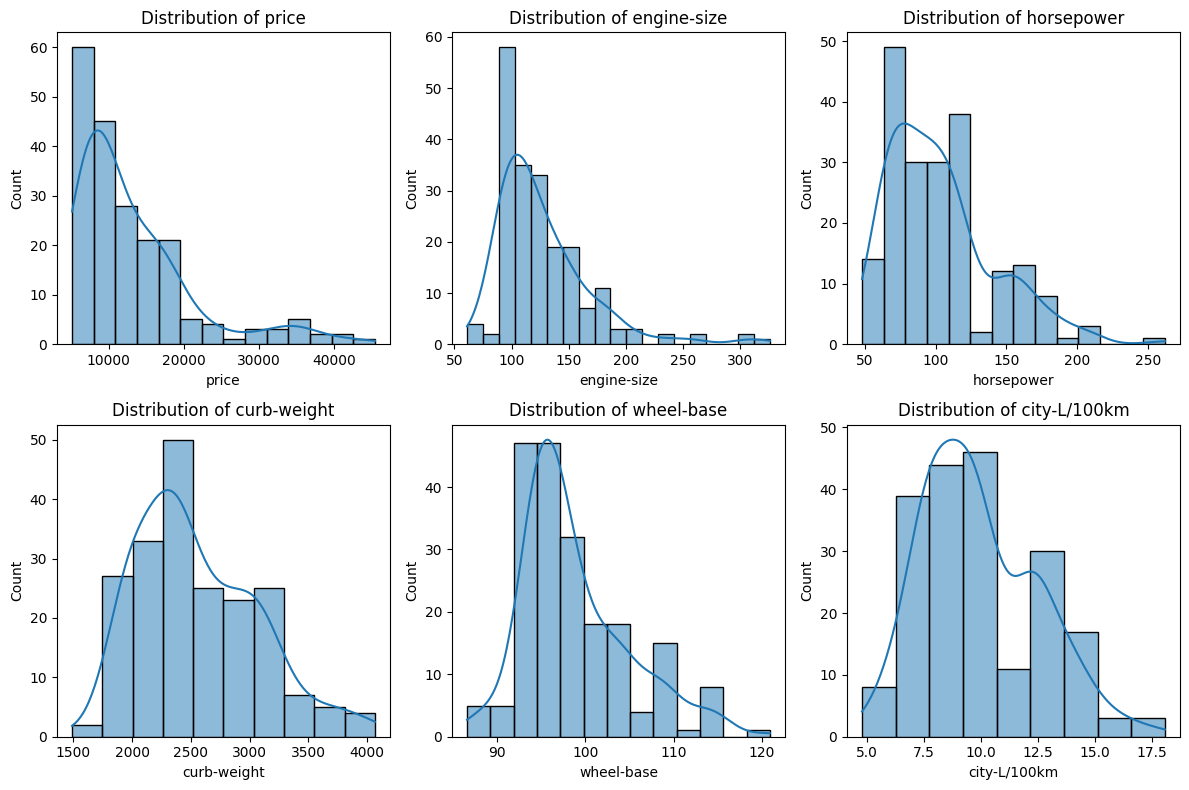

In [4]:
numerical_cols = ['price', 'engine-size', 'horsepower', 'curb-weight', 'wheel-base', 'city-L/100km']
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

4.2 Horsepower Binning

horsepower-binned
Low       153
Medium     43
High        5
Name: count, dtype: int64


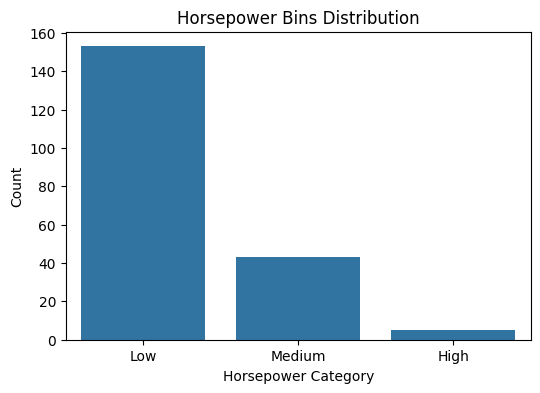

In [5]:
bins = np.linspace(df['horsepower'].min(), df['horsepower'].max(), 4)
group_names = ['Low', 'Medium', 'High']
df['horsepower-binned'] = pd.cut(df['horsepower'], bins, labels=group_names, include_lowest=True)
print(df['horsepower-binned'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='horsepower-binned', data=df)
plt.title('Horsepower Bins Distribution')
plt.xlabel('Horsepower Category')
plt.ylabel('Count')
plt.savefig('horsepower_bins.png')
plt.show()

4.3 Correlation Heatmap

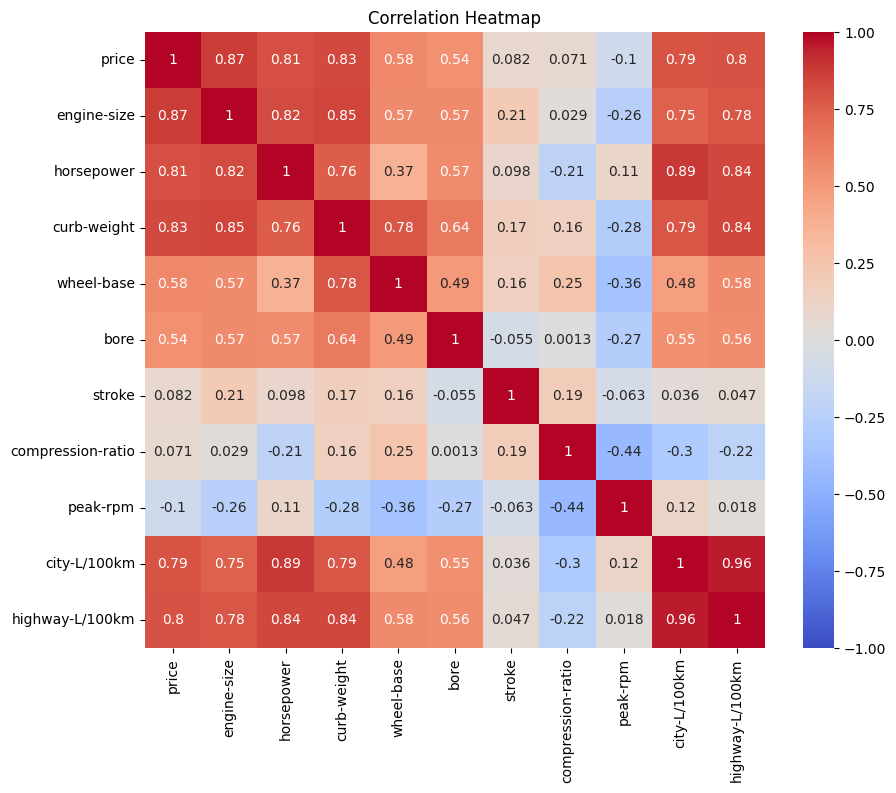

In [6]:
numerical_cols = ['price', 'engine-size', 'horsepower', 'curb-weight', 'wheel-base', 'bore', 'stroke', 'compression-ratio', 'peak-rpm', 'city-L/100km', 'highway-L/100km']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

4.4 Regression Plots

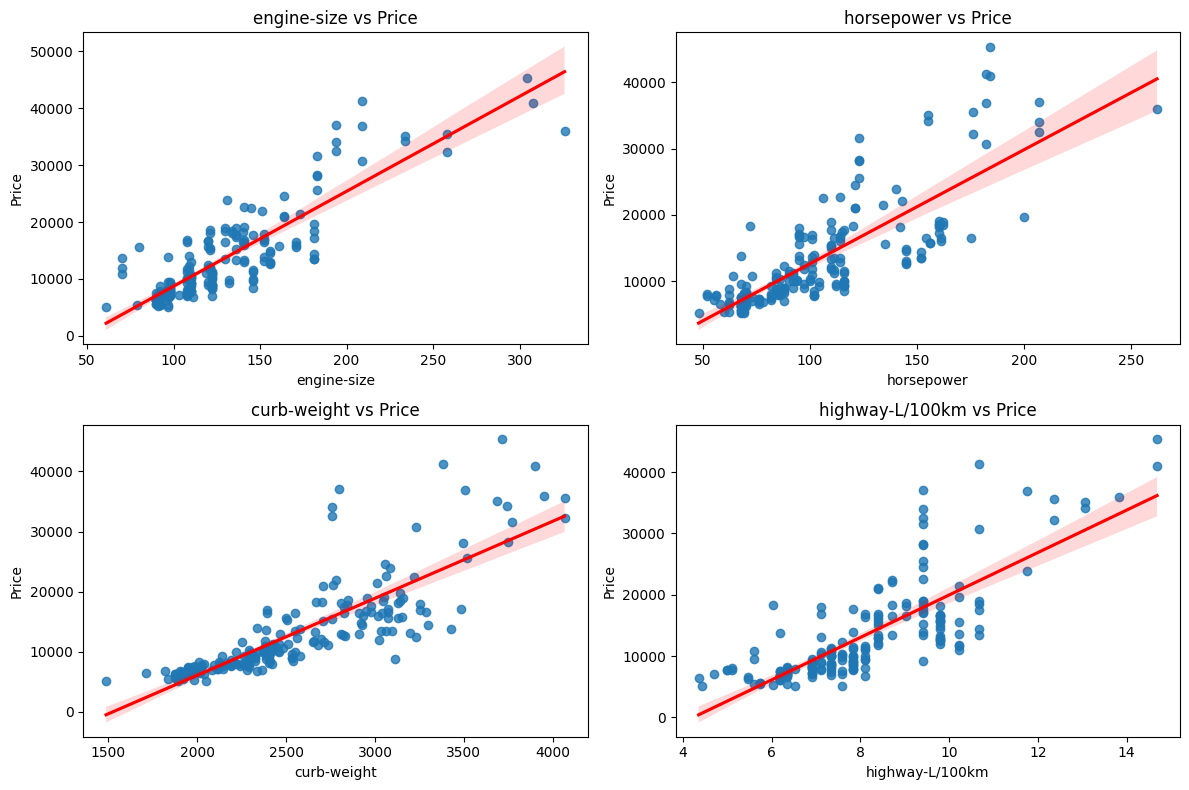

In [7]:
key_features = ['engine-size', 'horsepower', 'curb-weight', 'highway-L/100km']
plt.figure(figsize=(12, 8))
for i, col in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.regplot(x=col, y='price', data=df, line_kws={'color': 'red'})
    plt.title(f'{col} vs Price')
    plt.xlabel(col)
    plt.ylabel('Price')
plt.tight_layout()
plt.savefig('regression_plots.png')
plt.show()

4.5 Box Plots for Categorical Features

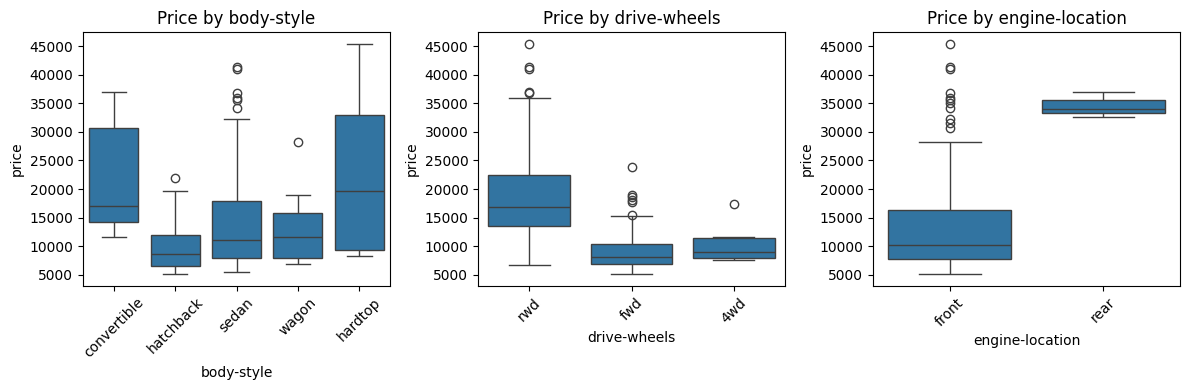

In [8]:
categorical_cols = ['body-style', 'drive-wheels', 'engine-location']
plt.figure(figsize=(12, 4))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=col, y='price', data=df)
    plt.title(f'Price by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('categorical_boxplots.png')
plt.show()

4.6 Pair Plot

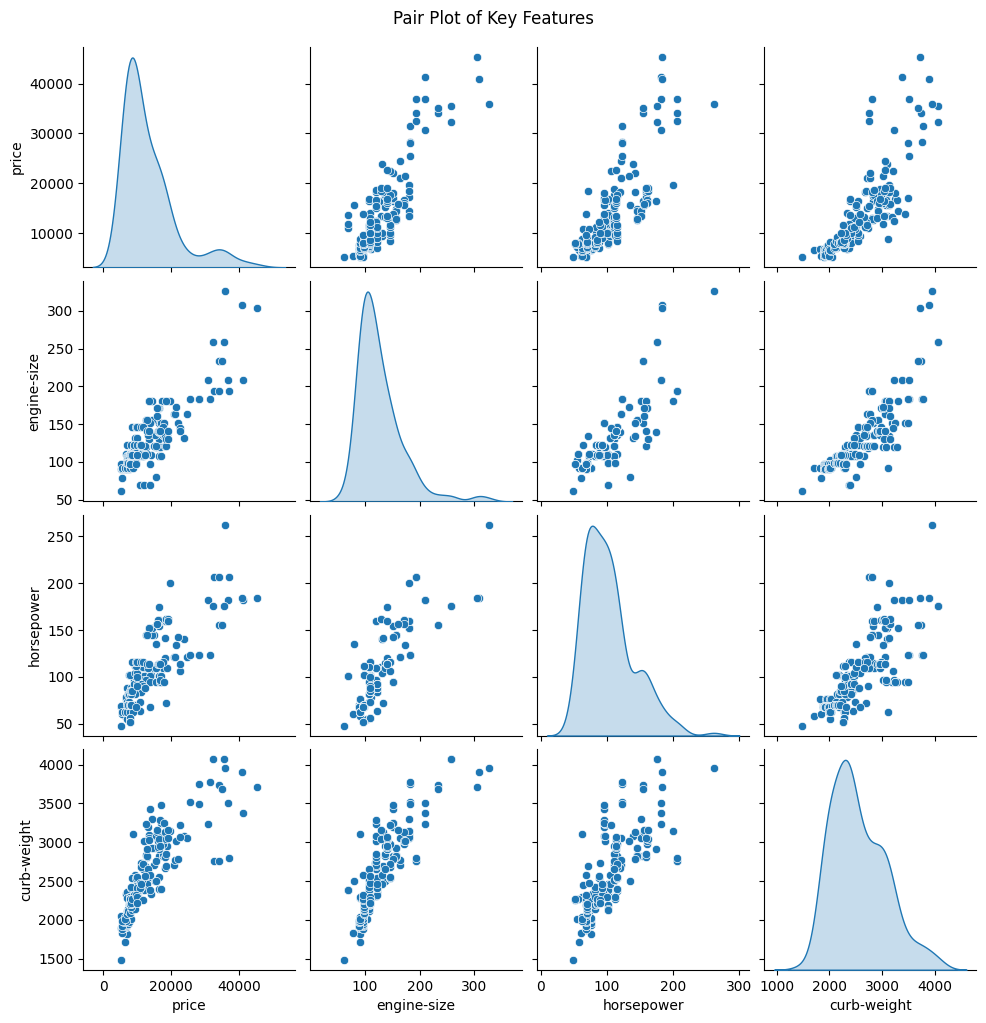

In [9]:
sns.pairplot(df[['price', 'engine-size', 'horsepower', 'curb-weight']], diag_kind='kde')
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.savefig('pair_plot.png')
plt.show()

5. Preprocessing

In [10]:
# Verify column names
print("Columns before encoding:", df.columns.tolist())

# Define columns to encode (adjust based on actual column names)
columns_to_encode = ['fuel_type', 'aspiration', 'body_style', 'drive_wheels', 'engine_location']

# Filter to include only columns that exist in the DataFrame
columns_to_encode = [col for col in columns_to_encode if col in df.columns]

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)
print("Encoded Columns:", df.columns.tolist())

Columns before encoding: ['symboling', 'normalized-losses', 'make', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'price', 'city-L/100km', 'horsepower-binned', 'diesel', 'gas', 'highway-L/100km']
Encoded Columns: ['symboling', 'normalized-losses', 'make', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'price', 'city-L/100km', 'horsepower-binned', 'diesel', 'gas', 'highway-L/100km', 'aspiration_turbo']


6. Model Development

6.1 Simple Linear Regression

Simple Linear Regression:
R² (Test): 0.5609826363054721
MSE (Test): 53712357.7752947


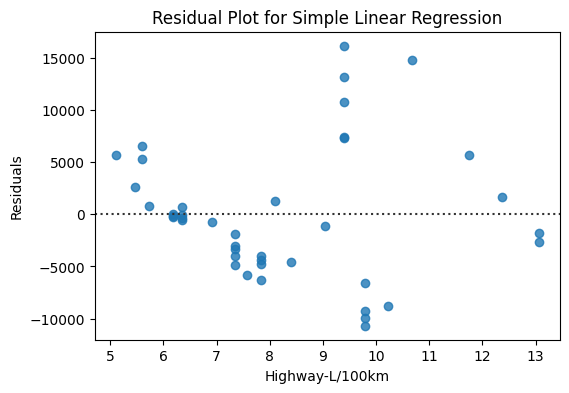

In [11]:
X = df[['highway-L/100km']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Simple Linear Regression:")
print("R² (Test):", r2_score(y_test, y_pred))
print("MSE (Test):", mean_squared_error(y_test, y_pred))

# Residual Plot
plt.figure(figsize=(6, 4))
sns.residplot(x=X_test['highway-L/100km'], y=y_test - y_pred)
plt.title('Residual Plot for Simple Linear Regression')
plt.xlabel('Highway-L/100km')
plt.ylabel('Residuals')
plt.savefig('simple_residual_plot.png')
plt.show()

6.2 Multiple Linear Regression

Multiple Linear Regression:
R² (Test): 0.7515805044988039
MSE (Test): 30393323.64540089


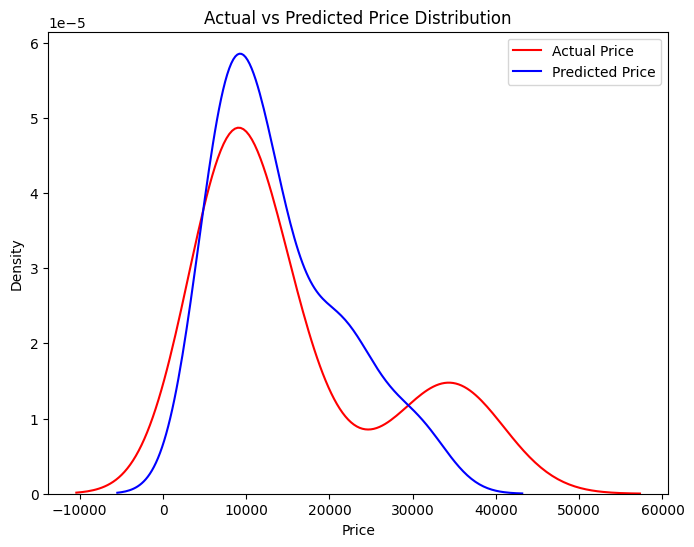

In [12]:
Z = df[['engine-size', 'horsepower', 'curb-weight', 'highway-L/100km']]
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=42)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Multiple Linear Regression:")
print("R² (Test):", r2_score(y_test, y_pred))
print("MSE (Test):", mean_squared_error(y_test, y_pred))

# Distribution Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, color='r', label='Actual Price')
sns.kdeplot(y_pred, color='b', label='Predicted Price')
plt.title('Actual vs Predicted Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.savefig('multiple_distribution_plot.png')
plt.show()

6.3 Polynomial Regression

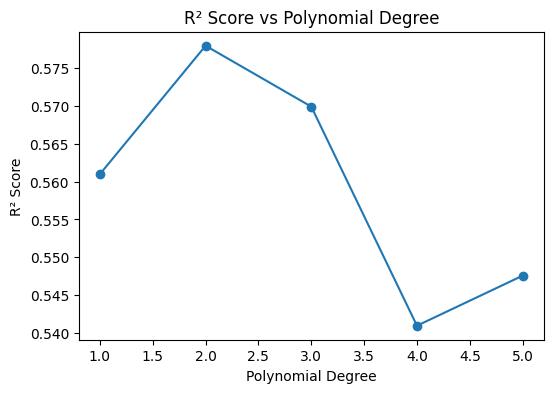

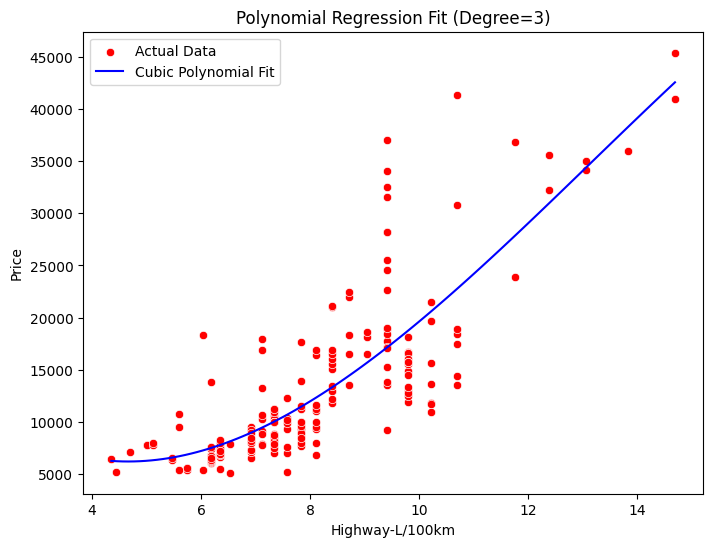

In [13]:
X = df[['highway-L/100km']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Rsqu_test = []
orders = [1, 2, 3, 4, 5]
for n in orders:
    pr = PolynomialFeatures(degree=n)
    X_train_pr = pr.fit_transform(X_train)
    X_test_pr = pr.transform(X_test)
    lr.fit(X_train_pr, y_train)
    Rsqu_test.append(lr.score(X_test_pr, y_test))

plt.figure(figsize=(6, 4))
plt.plot(orders, Rsqu_test, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² Score vs Polynomial Degree')
plt.savefig('polynomial_degree_comparison.png')
plt.show()

# Fit cubic polynomial for visualization
f = np.polyfit(X['highway-L/100km'], y, 3)
p = np.poly1d(f)
x_new = np.linspace(X['highway-L/100km'].min(), X['highway-L/100km'].max(), 100)
y_new = p(x_new)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['highway-L/100km'], y=y, color='red', label='Actual Data')
sns.lineplot(x=x_new, y=y_new, color='blue', label='Cubic Polynomial Fit')
plt.title('Polynomial Regression Fit (Degree=3)')
plt.xlabel('Highway-L/100km')
plt.ylabel('Price')
plt.legend()
plt.savefig('polynomial_fit.png')
plt.show()

6.4 Pipeline with Ridge Regression

In [14]:
Z = df[['engine-size', 'horsepower', 'curb-weight', 'highway-L/100km']]
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', Ridge(alpha=0.1))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Ridge Regression Pipeline:")
print("R² (Test):", r2_score(y_test, y_pred))
print("MSE (Test):", mean_squared_error(y_test, y_pred))

Ridge Regression Pipeline:
R² (Test): 0.7789158059095941
MSE (Test): 27048937.72654803


6.5 Cross-Validation

In [15]:
lr = LinearRegression()
scores = cross_val_score(lr, Z, y, cv=5, scoring='r2')
print("Cross-Validation R² Scores:", scores)
print("Mean R²:", scores.mean(), "Std:", scores.std())

Cross-Validation R² Scores: [0.78097164 0.84985413 0.16768044 0.55618381 0.33960077]
Mean R²: 0.5388581580397553 Std: 0.25811393362080304


7. Saving the Model



In [16]:
joblib.dump(pipeline, 'car_price_ridge_model.pkl')
print('Model saved as car_price_ridge_model.pkl')

Model saved as car_price_ridge_model.pkl
